In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import time
import nltk

from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

# Download stopwords
nltk.download('stopwords')

# Load data
df = pd.read_excel("game_data_50000.xlsx")
print('Total number of documents:', len(df))

# Preview the first 5 rows
df.head()

# Data cleaning functions
def _removeNonAscii(s):
    return "".join(i for i in str(s) if  ord(i) < 128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text


# Data cleaning
df['cleaned'] = df['short_description'].apply(_removeNonAscii)
df['cleaned'] = df['cleaned'].apply(make_lower_case)
df['cleaned'] = df['cleaned'].apply(remove_stop_words)
df['cleaned'] = df['cleaned'].apply(remove_punctuation)
df['cleaned'] = df['cleaned'].apply(remove_html)

# Remove empty rows
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('Total number of documents after cleaning:', len(df))

# Build Word2Vec model
corpus = [words.split() for words in df['cleaned']]
word2vec_model = Word2Vec(size=300, window=5, min_count=2, workers=-1) # make model
word2vec_model.build_vocab(corpus) # 
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True) # pre-trained data
word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs=15) 

# Get document vectors
def get_document_vectors(document_list, model):
    document_embedding_list = []
    
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.vocab:
                count += 1
                if doc2vec is None:
                    doc2vec = model[word]
                else:
                    doc2vec = doc2vec + model[word]
        if doc2vec is not None:
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)
    
    return document_embedding_list

document_embedding_list = get_document_vectors(df['cleaned'], word2vec_model)
print('Number of document vectors:', len(document_embedding_list))
print(document_embedding_list)

# Calculate cosine similarity matrix
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('Size of cosine similarity matrix:', cosine_similarities.shape)

def get_movie_indices(name, df, cosine_similarities):
    # Get the index of the movie based on its name
    indices = pd.Series(df.index, index=df['name']).drop_duplicates()
    idx = indices[name]

    # Get the indices of the most similar movies based on the cosine similarities
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]

    return movie_indices

def show_recommendations(name, df, cosine_similarities):
    movies = df[['name', 'image']]

    # Get the indices of the recommended movies
    movie_indices = get_movie_indices(name, df, cosine_similarities)

    # Get the recommended movies based on their indices
    recommend = movies.iloc[movie_indices].reset_index(drop=True)

    fig, axs = plt.subplots(1, 5, figsize=(20, 30))

    # Display the images of the recommended movies
    for index, row in recommend.iterrows():
        try:
            response = requests.get(row['image'])
            img = Image.open(BytesIO(response.content))
            axs[index].imshow(img)
            axs[index].set_title(row['name'])
        except:
            continue
    plt.show()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\multicampus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total number of documents: 57068
Total number of documents after cleaning: 53550


C:\Users\multicampus\AppData\Local\Temp\ipykernel_23488\3382616166.py:85: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = model[word]
C:\Users\multicampus\AppData\Local\Temp\ipykernel_23488\3382616166.py:87: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + model[word]


Number of document vectors: 53096


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Size of cosine similarity matrix: (53096, 53096)


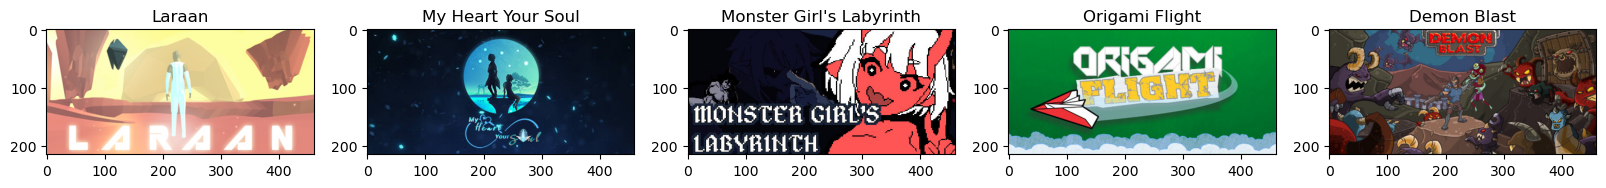

In [2]:
show_recommendations("uCallMeProducer101", df, cosine_similarities)

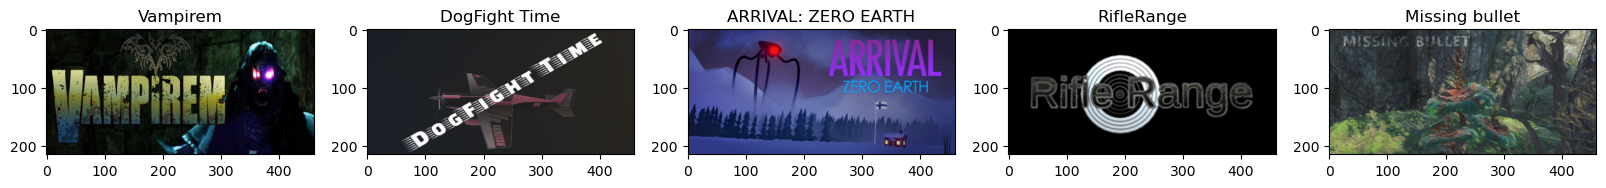

In [3]:
show_recommendations("ENEMIES", df, cosine_similarities)

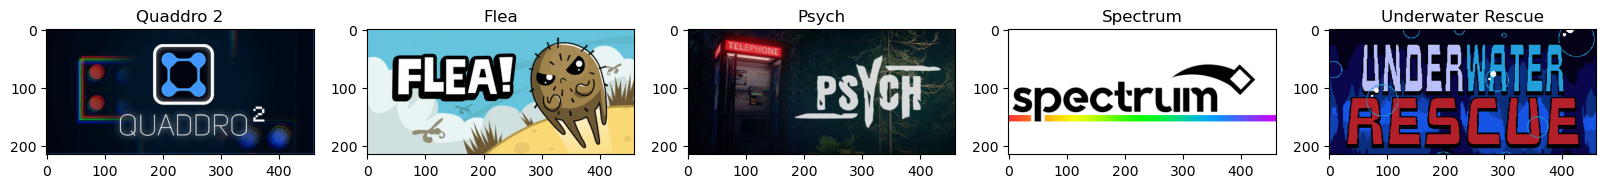

In [4]:
show_recommendations("Zombie Freaks", df, cosine_similarities)

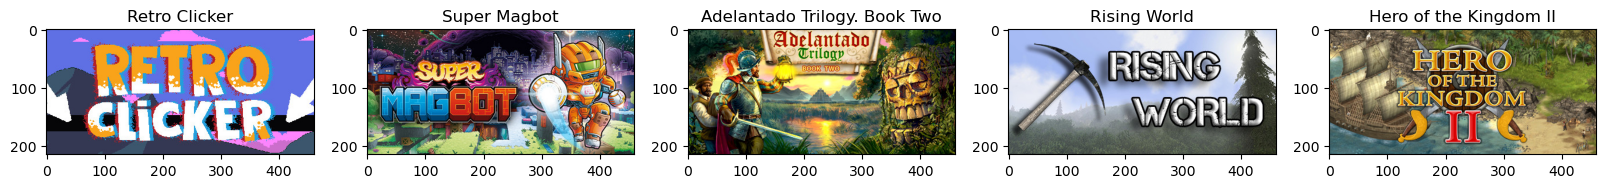

In [5]:
show_recommendations("OGgolf", df, cosine_similarities)

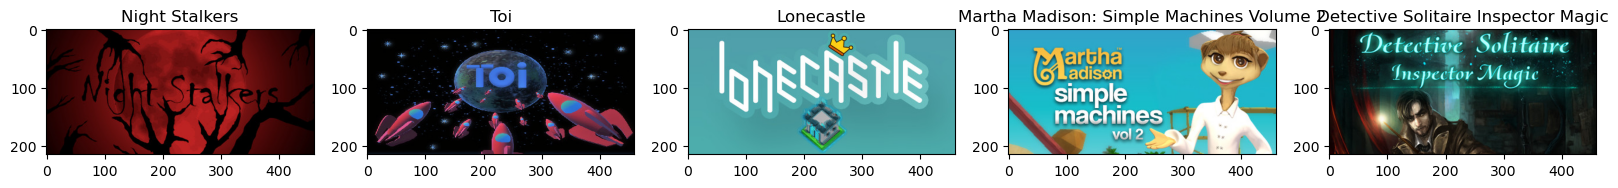

In [6]:
show_recommendations("The Hell Hives", df, cosine_similarities)

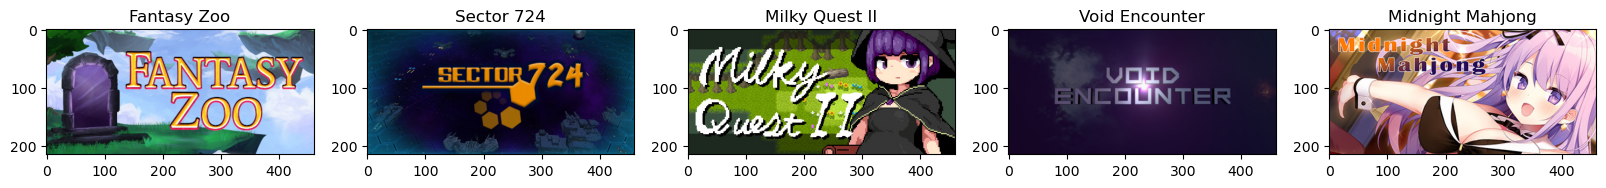

In [7]:
show_recommendations("MAZE: A VR Adventure", df, cosine_similarities)

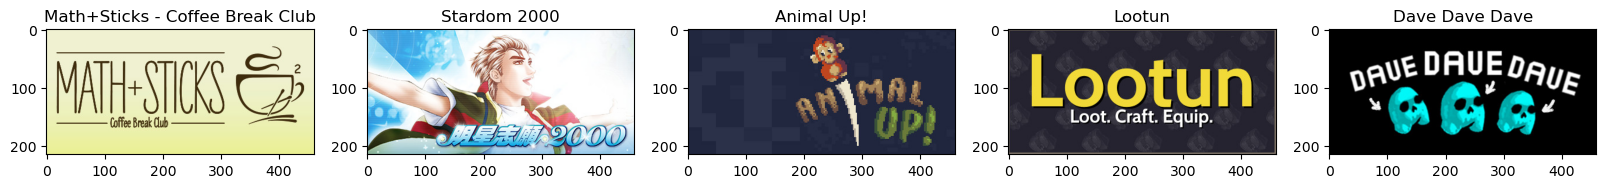

In [8]:
show_recommendations("Woods of Death 2", df, cosine_similarities)